In [1]:
!pip install tensorflow
!pip install keras

In [2]:
!pip install pythainlp
!pip install full
!pip install emoji
!pip install attacut


In [3]:
import tensorflow
from gensim.models import Word2Vec,KeyedVectors
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, LSTM,Bidirectional, Embedding, Dropout,BatchNormalization
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pythainlp
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize
import re
import string
from pythainlp.util import normalize
from pythainlp.tokenize import newmm

2024-09-18 06:55:37.285397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 06:55:38.828660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
x_train = pd.read_csv('csv/x_train.csv',encoding='utf-8')
x_test = pd.read_csv('csv/x_test.csv',encoding='utf-8')

In [5]:
y_train = pd.read_csv('csv/y_train.csv',encoding='utf-8')
y_test = pd.read_csv('csv/y_test.csv',encoding='utf-8')

In [6]:
model = Word2Vec.load('model/w2v_model2.bin')

In [7]:
texts =list(model.wv.vectors)
texts[:2]

[array([ 1.20372303e-01,  9.29484144e-02,  6.85946643e-02,  1.50038034e-01,
        -2.83760905e-01,  8.87635499e-02, -1.02474444e-01,  2.21731126e-01,
        -3.97178650e-01,  1.75928727e-01,  2.20886692e-01, -1.85588971e-04,
         1.40436187e-01, -8.23967531e-02,  3.02380547e-02, -2.11364523e-01,
        -4.09234539e-02, -3.05023521e-01,  3.73513065e-02, -2.97104865e-01,
         1.82141885e-01,  1.33471236e-01, -9.39088687e-02,  1.06301919e-01,
         6.31590709e-02, -4.06616360e-01, -6.58264682e-02, -1.87956855e-01,
        -3.49155456e-01, -6.54971451e-02, -3.13769802e-02, -6.98488876e-02,
         1.53916046e-01, -3.60157676e-02,  1.29938141e-01, -1.75805077e-01,
         1.99296892e-01, -1.55739263e-01, -1.25182673e-01, -8.76163766e-02,
        -1.82492331e-01,  1.29576866e-02, -4.45794091e-02, -1.95761591e-01,
         1.79394066e-01,  3.75305712e-02,  2.13382646e-01,  2.09209085e-01,
         1.04048595e-01,  3.70577365e-01, -1.44880548e-01, -4.90906090e-02,
        -1.7

In [8]:
def cleanText(sentences):
    tokenized_sentences = []
    cleaned_sentences = []  # เพิ่มคอลัมน์เก็บประโยคที่ทำความสะอาดแล้ว
    
    for txt in sentences:
        # แปลงเป็น string
        t = str(txt)

        # ลบตัวอักษรที่ไม่ใช่ภาษาไทย
        cleaned_text = re.sub('[^ก-๙]', '', t)

        # Normalize ข้อความ (เช่น การปรับสระให้เป็นรูปแบบเดียวกัน)
        normalized_text = normalize(cleaned_text)

        # ดึง stopwords ภาษาไทย
        stop_words = set(thai_stopwords())

        # ตัดคำโดยใช้ engine "newmm" สำหรับการตัดคำภาษาไทย
        words = word_tokenize(normalized_text, engine="newmm")

        # ลบ stopwords และคำที่มีช่องว่าง
        filtered_words = [word for word in words if word not in stop_words and word.strip()]

        # แปลงเป็น lowercase
        tokenized_sentence = [word.lower() for word in filtered_words]

        # เก็บผลลัพธ์ของการตัดคำ
        tokenized_sentences.append(tokenized_sentence)

        # เก็บผลลัพธ์ของประโยคที่ทำความสะอาดแล้ว
        cleaned_sentence = " ".join(tokenized_sentence)
        cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences, tokenized_sentences  # คืนค่า 2 ค่า: ประโยคที่ทำความสะอาดแล้ว และการตัดคำ

In [9]:
x_train

,body
0,ช่วงค่ำวันที่ 29 เม.ย. 67 ผู้สื่อข่าวลงพื้นที่...
1,ราคาน้ำมันพรุ่งนี้' 18 มิถุนายน 2566 อัปเดตล่า...
2,Jordan 1 low OG 💙🤍🖤BLACKDARK POWDER BLUE “UNC”...
3,นางอังคณา นีละไพจิตร ส.ว. ให้สัมภาษณ์ภายหลังมี...
4,ศบค.เผย ไทยพบป่วยโควิด “โอมิครอน” แล้ว 514 ราย...
...,...
6981,กรมการแพทย์แผนไทยและการแพทย์ทางเลือก เผยเคล็ดล...
6982,“พลังงาน” แจงแผน PDP ใหม่เม็ดเงินลงทุนโครงสร้า...
6983,ชี้ช่องปรับปรุง-ขึ้นทะเบียนเกษตรกร ทำเองได้ง่า...
6984,กรณีที่มีการพบช่อง TikTok ทางรัฐ ทำการประชาสัม...


In [10]:
x_train['cleantext'], tokenized_sentences = cleanText(x_train['body'])

In [11]:
x_test['cleantext'], tokenized_sentences = cleanText(x_test['body'])

In [12]:
x_train

,body,cleantext
0,ช่วงค่ำวันที่ 29 เม.ย. 67 ผู้สื่อข่าวลงพื้นที่...,ค่ำ วันที่ เม ย ผู้สื่อข่าว พื้นที่ ชายหาด จอม...
1,ราคาน้ำมันพรุ่งนี้' 18 มิถุนายน 2566 อัปเดตล่า...,ราคา น้ำมัน พรุ่งนี้ มิถุนายน อัปเดต เบนซิน แก...
2,Jordan 1 low OG 💙🤍🖤BLACKDARK POWDER BLUE “UNC”...,สี สวย เต็ม ใส่ เท่ ส ไตร ์ ราคา เริ่มต้น ฿ คร...
3,นางอังคณา นีละไพจิตร ส.ว. ให้สัมภาษณ์ภายหลังมี...,อังคณา นี ไพจิตร สว สัมภาษณ์ รายชื่อ แคนดิเดต ...
4,ศบค.เผย ไทยพบป่วยโควิด “โอมิครอน” แล้ว 514 ราย...,ศบค เผย ไทย ป่วย โควิด โอ มิค รอน ระบาด จังหวั...
...,...,...
6981,กรมการแพทย์แผนไทยและการแพทย์ทางเลือก เผยเคล็ดล...,กรมการแพทย์ แผน ไทย การแพทย์ ทางเลือก เผย เคล็...
6982,“พลังงาน” แจงแผน PDP ใหม่เม็ดเงินลงทุนโครงสร้า...,พลังงาน แจง แผนใหม่ เม็ด เงินลงทุน โครงสร้างพื...
6983,ชี้ช่องปรับปรุง-ขึ้นทะเบียนเกษตรกร ทำเองได้ง่า...,ชี้ช่อง ปรับปรุง ขึ้นทะเบียน เกษตรกร ทำ รักษา ...
6984,กรณีที่มีการพบช่อง TikTok ทางรัฐ ทำการประชาสัม...,กรณี ช่องทาง รัฐ ทำการ ประชาสัมพันธ์ ข่าวสาร โ...


In [13]:
def get_average_vector(text):
    tokens = word_tokenize(text, engine="newmm")
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [14]:
X_train_vectors = [get_average_vector(text) for text in x_train['cleantext']]
X_test_vectors = [get_average_vector(text) for text in x_test['cleantext']]

In [15]:
X_train_vectors[2]

array([ 0.26905584, -0.22324249,  0.13365088,  0.34491634, -0.02297693,
        0.03725982, -0.3540036 ,  0.52671164,  0.12013485,  0.37178516,
       -0.03476809, -0.00874178,  0.3289362 ,  0.17308214, -0.28886068,
       -0.30595294, -0.00900772, -0.21231678,  0.09938603,  0.09263161,
        0.1218942 ,  0.08574659,  0.15130578, -0.1346704 ,  0.01284845,
       -0.18100736, -0.22417378,  0.1005861 , -0.21968363, -0.1315763 ,
       -0.14022636, -0.02024314, -0.11768577, -0.05402915,  0.26174444,
       -0.10780291, -0.0128191 , -0.10889172, -0.20246255,  0.07236193,
       -0.01445011, -0.31537616, -0.02403055, -0.08073574,  0.11375327,
        0.00668085,  0.09303015, -0.16439562,  0.08113912,  0.07791312,
        0.06916854, -0.13596618,  0.07671786, -0.1656702 , -0.06445487,
       -0.14585997,  0.16070674, -0.23186183,  0.22387882, -0.15562396,
        0.36511445,  0.1218228 ,  0.13295081, -0.18830976, -0.10091873,
       -0.11017945, -0.23060663,  0.33161378,  0.02927967, -0.10

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [17]:
def reduce_dimension_with_tsne(vectors, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state)
    vectors_array = np.array(vectors)
    return tsne.fit_transform(vectors_array)


In [18]:
X_train_tsne = reduce_dimension_with_tsne(X_train_vectors)
X_test_tsne = reduce_dimension_with_tsne(X_test_vectors)

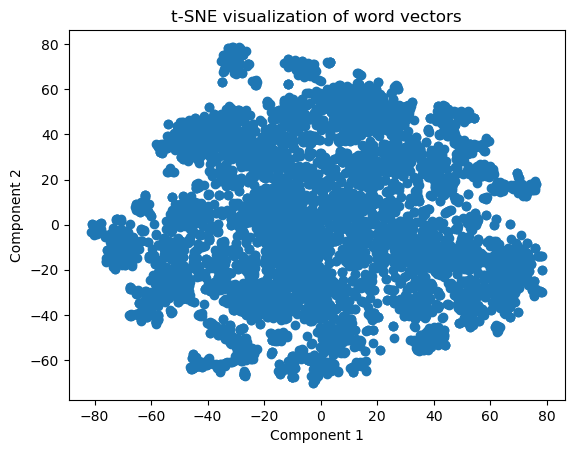

In [19]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
plt.title("t-SNE visualization of word vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [20]:
X_train_tsne[:5]

array([[ 18.871391 ,   9.029343 ],
       [-26.770275 , -66.732285 ],
       [ -0.8906621, -36.923737 ],
       [-54.6924   ,  35.156532 ],
       [ 39.635227 , -16.87843  ]], dtype=float32)

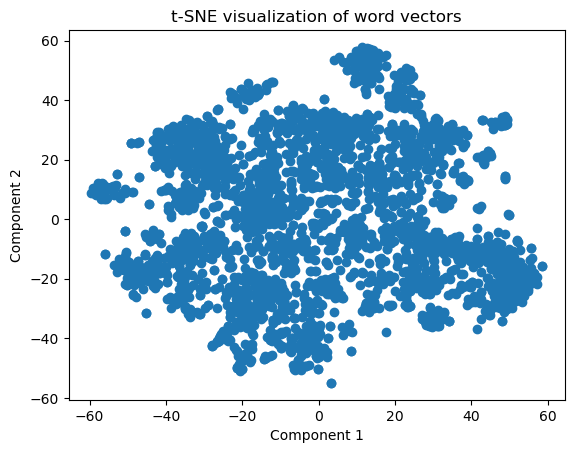

In [21]:
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1])
plt.title("t-SNE visualization of word vectors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [23]:
# ตรวจสอบขนาดของข้อมูล
print(len(X_train_tsne), len(y_train))

6986 6986


In [24]:
clf = LogisticRegression()
clf.fit(X_train_tsne, y_train)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [25]:
y_pred = clf.predict(X_test_tsne)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.89      1.00      0.94      2677

    accuracy                           0.89      2994
   macro avg       0.45      0.50      0.47      2994
weighted avg       0.80      0.89      0.84      2994



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
from sklearn.ensemble import RandomForestClassifier

# ใช้ Random Forest เป็นโมเดล
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train_tsne, y_train)

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [27]:
y_pred = RF.predict(X_test_tsne)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.01      0.01       317
           1       0.89      0.98      0.93      2677

    accuracy                           0.88      2994
   macro avg       0.46      0.49      0.47      2994
weighted avg       0.80      0.88      0.84      2994

